<center>
    <h3> Real-Time Time Dependent Orbital Free Density Functional Theory with DFTpy</h3>
    <h3>Part 1: $T_s \sim T_{TF}+T_{vW}$</h3>
</center>
<table>
  <tr>
      <td><p><h4>Rutgers University-Newark</h4></p><p>Team Rutgers</p></td>
           <td><img src="../figures/logos/run.png" width=300 height=300 /></td>
  </tr>
</table>

<center><h3>ASESMA 2025</h3></center>

## This notebook will:
#### 1) Obtain the Optical Spectrum of a Mg<sub>8</sub> cluster using DFTpy
#### 2) Compare against the more accurate KS-TDDFT method (precalculated)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [5]:
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF

--2025-06-09 08:44:11--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
Resolving gitlab.com (gitlab.com)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘gitlab.com’
--2025-06-09 08:44:12--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF
Resolving gitlab.com (gitlab.com)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘gitlab.com’


### Read the vasp file with DFTpy

In [6]:
ions = io.read('Mg8.vasp', format='vasp', names=['Mg'])

<Axes: >

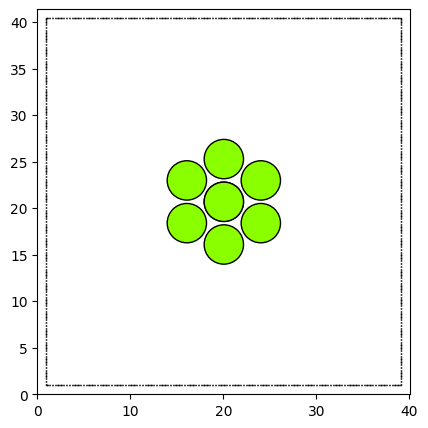

In [32]:
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(ions, ax, radii=1.5, rotation=('0x,0y,0z'))

### Create the PP list and the Grid
DirectGrid is a class object that represents a grid (Cell plus discretization)

In [7]:
PP_list = ['./Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [8]:
grid.nr

array([36, 36, 32], dtype=int32)

### Define XC, PSEUDO and HARTREE functionals

In [9]:

xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)


setting key: Mg -> ./Mg_OEPP_PZ.UPF


### Initial guess of the electron density: UEG

In [10]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

### Write the optimization options and build the class that handles the electron density optimization

#### Run the optimization of the electronic density with TF0.2vW ($T_s[n]\sim T_{TF}[n]+ T_{vW}[n]$)

- The Thomas Fermi functional is
$$ T_{TF}[n] = C_{TF} \int n^{5/3}(r)dr $$

- The von Weizsacker functional is
$$ T_{vW}[n] = -\frac{1}{2} \int \sqrt{n(r)} \nabla^2 \sqrt{n(r)} dr $$



In [11]:
optimization_options = {'econv' : 1e-9,'maxiter' : 100}
ke = Functional(type='KEDF',name='TFvW')

totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

In [12]:
 rho0 = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       5.218101E-02    
!WARN: Change to steepest decent
1       -4.970850195117E+00     -1.392277E+01   1.121758E+00    1       3       8.385301E-02    
2       -5.991894359401E+00     -1.021044E+00   1.516348E-01    4       2       1.221960E-01    
3       -6.128065564511E+00     -1.361712E-01   1.802914E-02    8       3       1.824939E-01    
4       -6.143827132639E+00     -1.576157E-02   3.111799E-03    10      3       2.524378E-01    
5       -6.146022420271E+00     -2.195288E-03   3.902282E-04    7       3       3.037088E-01    
6       -6.146449722646E+00     -4.273024E-04   4.586762E-05    10      3       3.710818E-01    
7       -6.146493565256E+00     -4.384261E-05   6.805996E-06    7       3       4.203010E-01    
8       -6.146501642729E+00     -8.077473E-06   7.757266E-07    10      2       4.830351E-01  

In [13]:
rho0.write(filename="rho_tfvw.xsf", ions=ions)

# OF-TDDFT real-time propagation
### Get the Pauli potentials by removing the von Weizsacker kinetic energy from the $T_s$ functional

Remember: 

$$
[-\frac{1}{2}\nabla ^2 + v_B(\mathbf{r},t)]\phi_B(\mathbf{r},t) = \mu \phi_B(\mathbf{r},t)
$$

The Boson potential is:

$$
v_B(\mathbf{r},t)= v_s(\mathbf{r})+v_p(\mathbf{r},t)+v_{appl}(\mathbf{r},t)
$$

The Pauli potential:

$$
v_p(\mathbf{r},t) = v_{Ts}(\mathbf{r},t) - v_{vW}(\mathbf{r},t)
$$


In [12]:
ke.options.update({'y':0}) # y is the fraction of vW in the functional. We set it to 0 to retrieve only the Pauli part.

## Time propagation after `kick`
Give momentum $k$ along specific direction to each KS orbital

$$
\phi(r,t_0) = \phi(r) e^{ikr}
$$

In [13]:
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
ha = ENERGY_CONV['Hartree']['eV']

k = 0.01*bohr
interval = 1.0 * as2au
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively

## Run with Crank Nicholson propagator

In [15]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [16]:
max_steps = 5000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [5000/5000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [17]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

## Extraction of the optical spectrum

The time-dependent dipole moment change:
$$
\delta\mu(t) = \mu(t)-\mu(t_0)
$$

is related to the oscillator strength by Fourier transform
$$
S(\omega)=-\frac{2\omega}{k\pi}  \delta\mu(\omega) = -\frac{2\omega}{k\pi} \int_{t_0}^{t} \delta\mu(t)e^{i\omega t} dt 
$$

## Plot the dipole moment

Text(0, 0.5, 'Dipole Moment (au)')

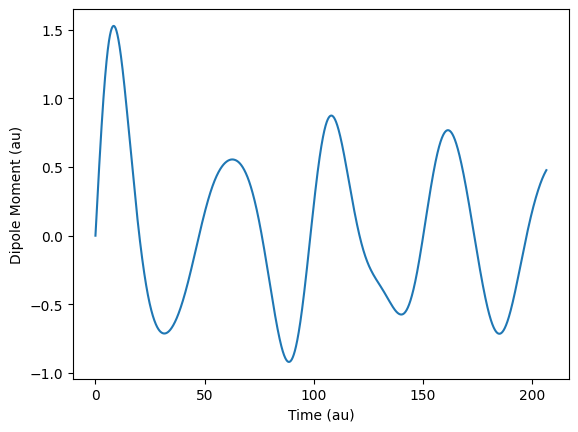

In [18]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

## Plot the optical spectra

In [33]:
KS_spectrum = np.loadtxt(fname='./KS_clusters/Mg8/Mg8_KS_spectrum.txt')

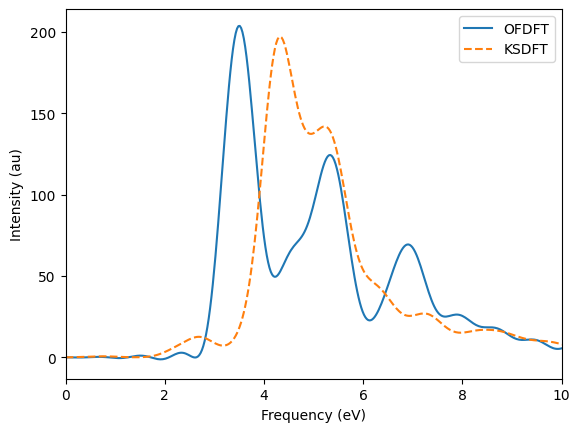

In [34]:
sigma = 0.03*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, sigma=sigma, kick=k)
plt.plot(omega*Units.Ha, spectra, '-', label='OFDFT')
plt.plot(KS_spectrum[0], KS_spectrum[1], '--', label='KSDFT')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 10)
plt.legend()

In [35]:

rho_lmgp = rho0.copy() # initialize the rho_lmgp variable

rho_lmgp.read(filename='./Mg8_rho_lmgp.xsf') # read precomputed LMGP density


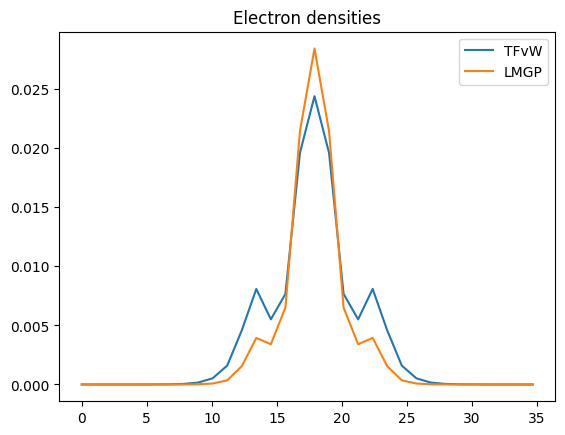

In [29]:
plt.plot(rho0.grid.r[2,15,15,:],rho0[18,18,:],label=r"TFvW")
plt.plot(rho0.grid.r[2,15,15,:],rho_lmgp[18,18,:],label=r"LMGP")
plt.title("Electron densities")
plt.legend()

# Clearly TFvW is not very good as the density is very different form LMGP, which is an accurate functional.

# Let's fire up Part 2!